In [1]:
import os
import sys
import itertools
import math
import logging
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

ROOT_DIR = os.path.abspath("/home/koukouzas/CODE/Mask_RCNN/")
# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

Using TensorFlow backend.


In [2]:
import wad
config = wad.WadConfig()
WAD_DATA = os.path.abspath("/home/koukouzas/CODE/Mask_RCNN/data/")

In [3]:
dataset = wad.WadDataset()
dataset.load_wad(WAD_DATA, "train")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Base dir : /home/koukouzas/CODE/Mask_RCNN/data/train_val/train
Data loaded from : /home/koukouzas/CODE/Mask_RCNN/data/train_val/train/image
35300 files
Image Count: 35300
Class Count: 8
  0. BG                                                
  1. car                                               
  2. motorcycle                                        
  3. bicycle                                           
  4. pedestrian                                        
  5. truck                                             
  6. bus                                               
  7. tricycle                                          


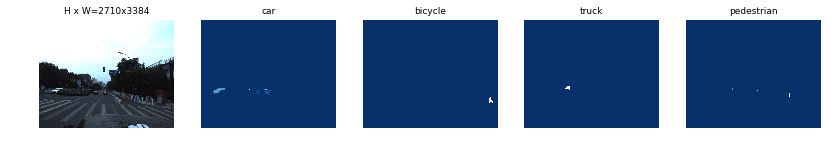

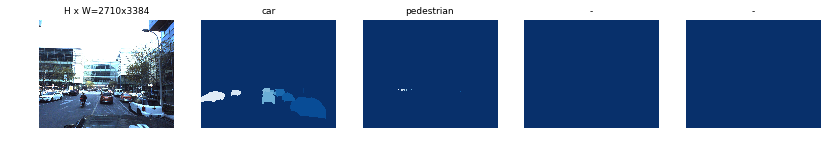

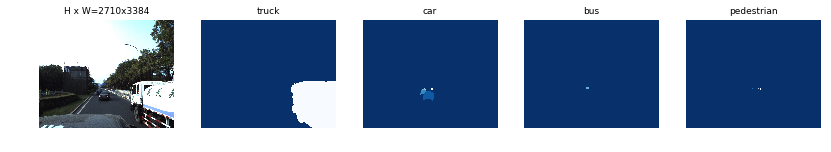

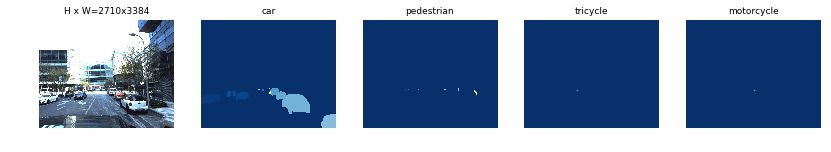

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

imag_id  5894 170927_070306120_Camera_6.jpg
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2710, 3384, 39)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (39,)                 min:    1.00000  max:    7.00000  int32
bbox                     shape: (39, 4)               min:    0.00000  max: 3384.00000  int32


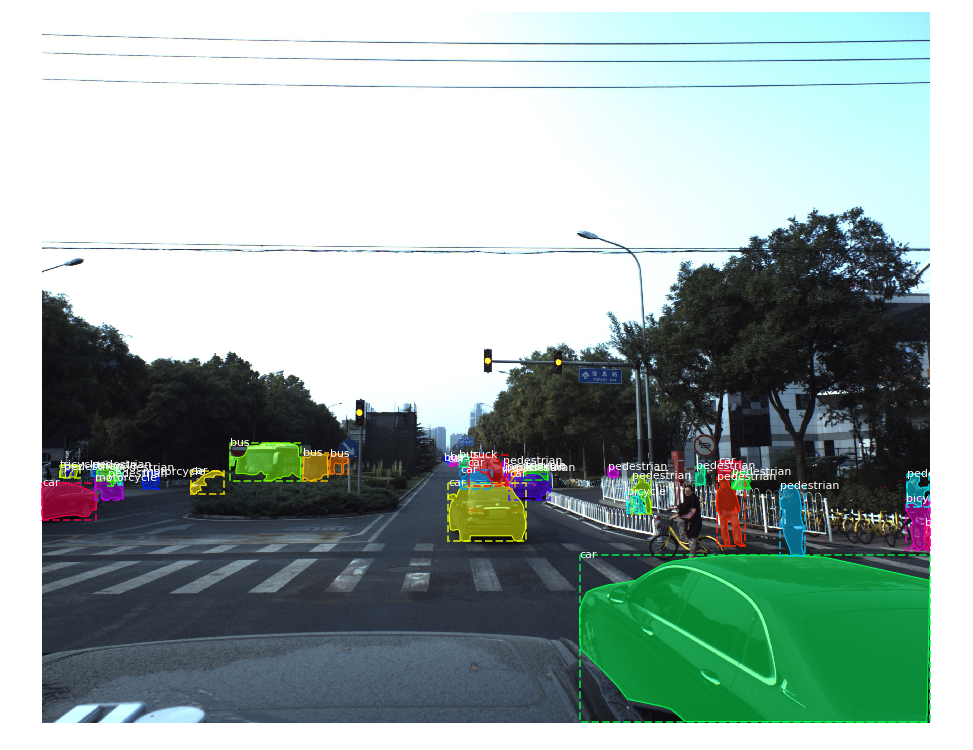

In [5]:
# Load random image and mask
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("imag_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  32831 170908_075400181_Camera_5.jpg
Original shape:  (2710, 3384, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (6,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (6, 4)                min:  474.00000  max:  844.00000  int32


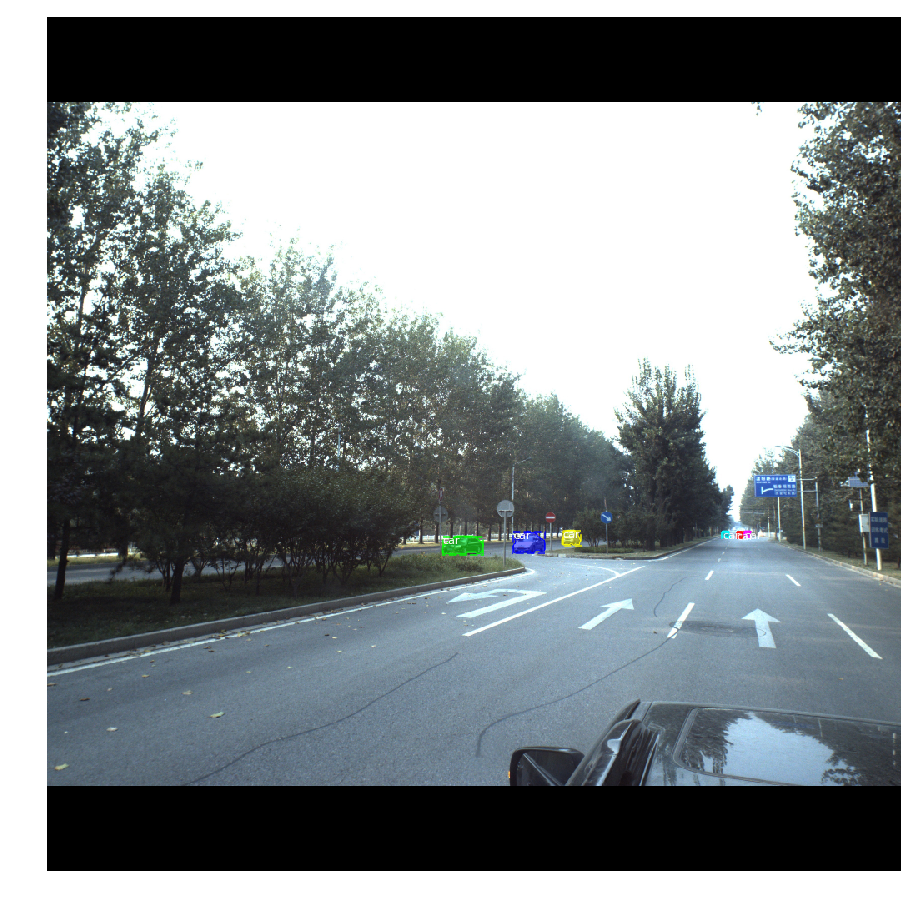

In [6]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ =utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image ten the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone.

To improve training speed, we optimize masks by: 

* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we can save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects, that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accurate to begin with, so this loss is negligable for the most practical purposes. This size of the mini_mask can be set in the config class.

Visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (20,)                 min:    0.00000  max: 29396.00000  float64
class_ids                shape: (10,)                 min:    1.00000  max:    5.00000  int32
bbox                     shape: (10, 4)               min:  611.00000  max:  990.00000  int32


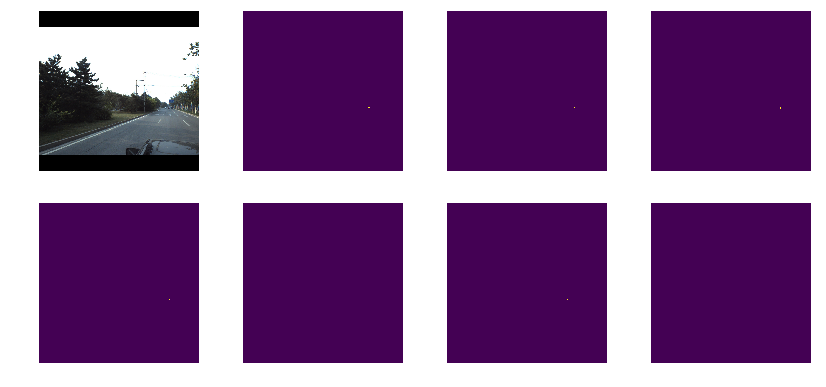

In [7]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)

display_images([image]+[mask[:, :, i] for i in range(min(mask.shape[-1], 7))])

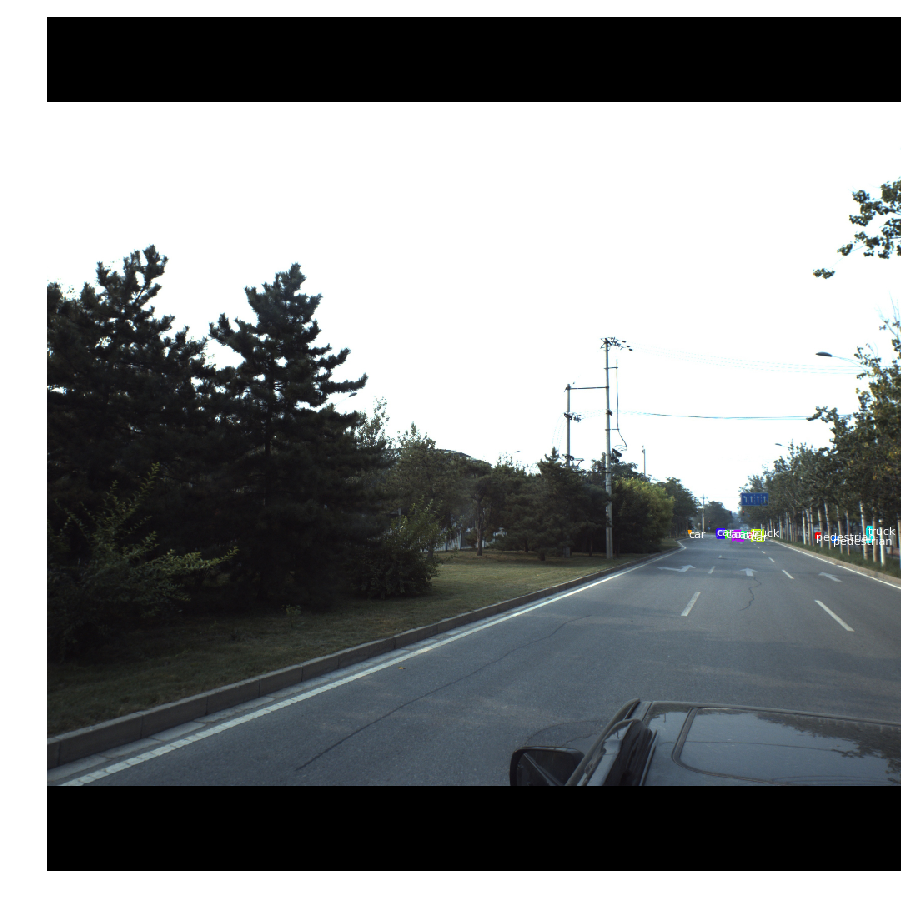

In [8]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 10)          min:    0.00000  max:    1.00000  bool


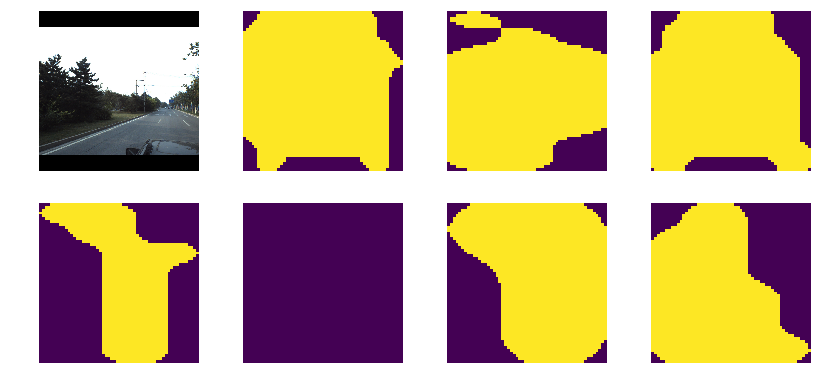

In [9]:
from imgaug import augmenters as iaa
augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augmentation=augmentation, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

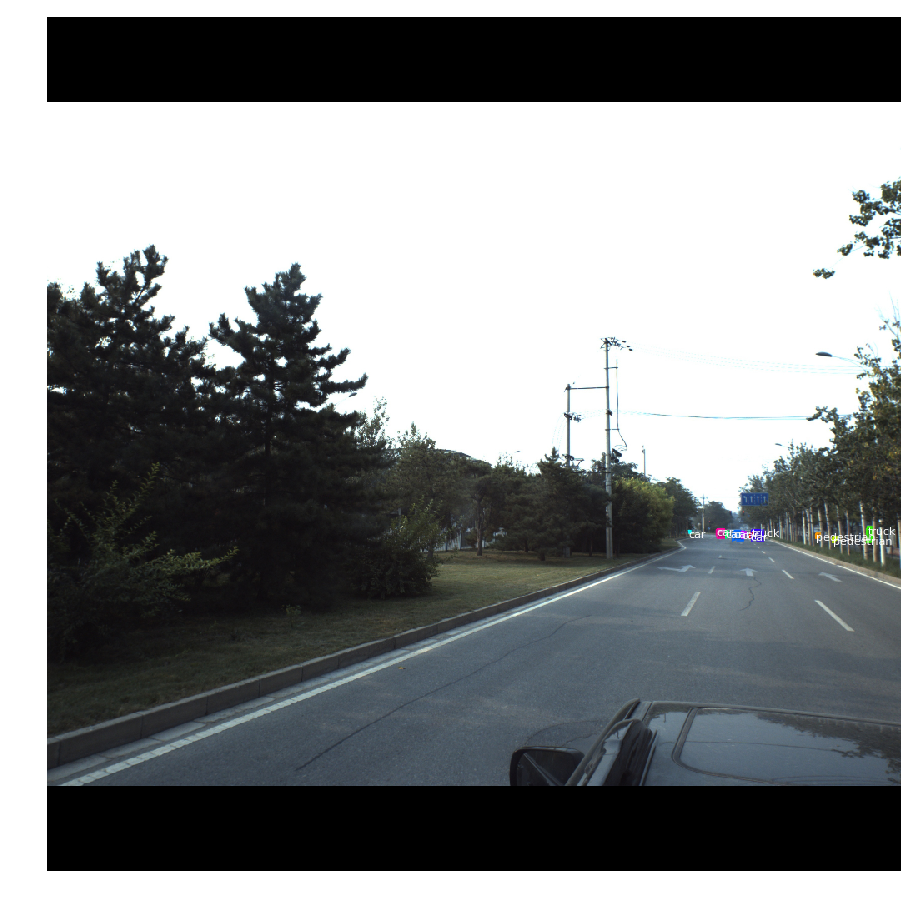

In [10]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:** In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (2562563). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.

In [11]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES,
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("Ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (8, 16, 32, 64, 128)
Ratios:  [0.5, 1, 2]
Anchors per cell:  3
Levels:  5
Anchors in level 0: 196608
Anchors in level 1: 49152
Anchors in level 2: 12288
Anchors in level 3: 3072
Anchors in level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


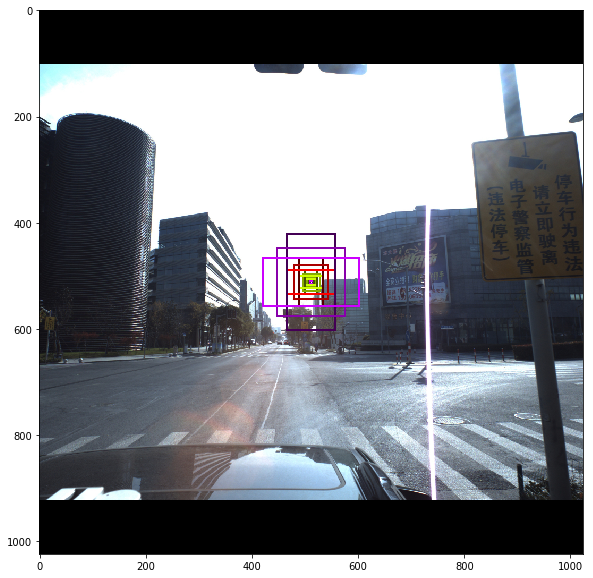

In [12]:
# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)
 

# Data Generator

In [4]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois,
    batch_size=4,
    detection_targets=True)

In [5]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
for i in range(1000):
    print(i)
    _, _ = next(g)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 600, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 600, 1)           min:    0.00000  max:    7.00000  int32
mrcnn_bbox               shape: (4, 600, 8, 4)        min:   -3.33333  max:    3.33333  float32
mrcnn_mask               shape: (4, 600, 28, 28, 8)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 200)              min:    0.00000  max:    7.00000  int32
gt_boxes                 shape: (4, 200, 4)           min:    0.00000  max: 1024.00000  int32
gt_masks                 shape: (4, 56, 56, 200)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 320, 4)           min:   -6.93147  max:    3.97748  float64
image_id:  16040 170908_061659828_Camera_5.jpg


anchors                  shape: (261888, 4)           min:  -90.50967  max: 1050.50967  float64
refined_anchors          shape: (4, 4)                min:  370.00000  max:  875.00000  float32
Positive anchors: 4
Negative anchors: 316
Neutral anchors: 261568
BG                     : 571
car                    : 21
tricycle               : 8


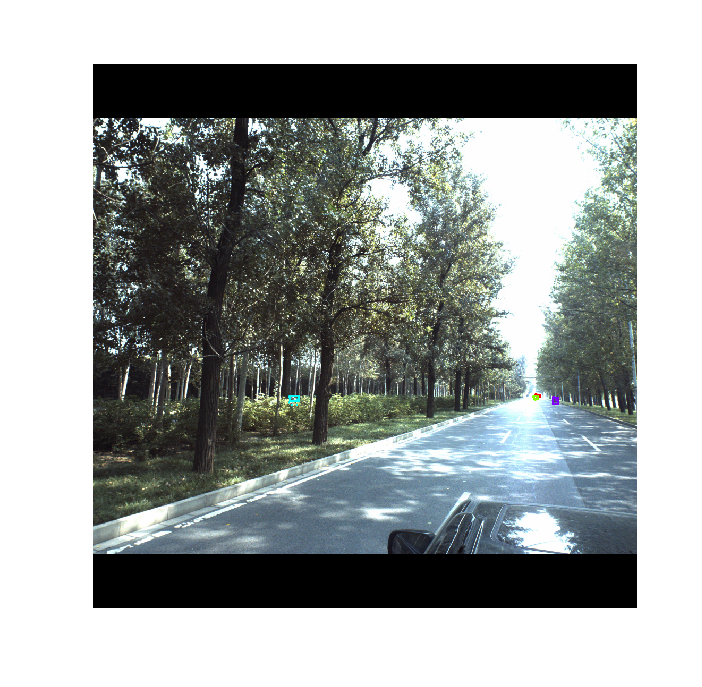

In [18]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

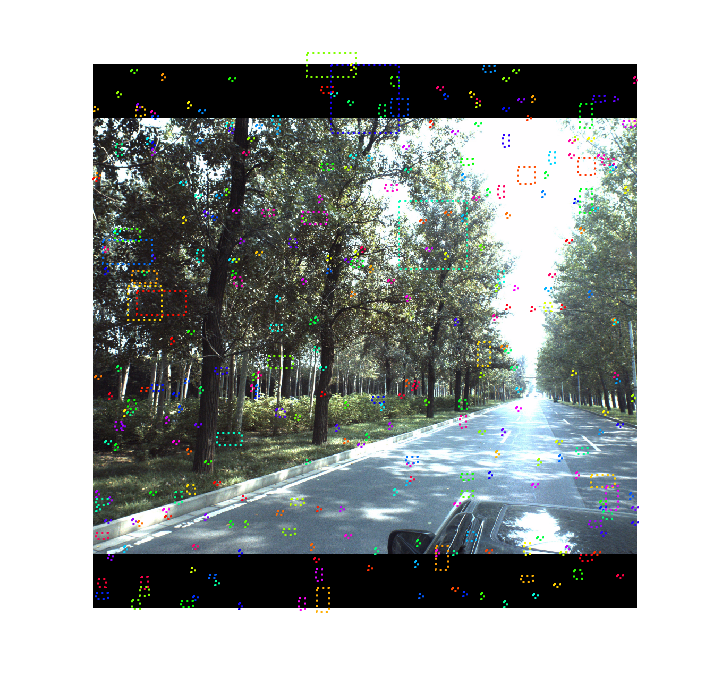

In [19]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

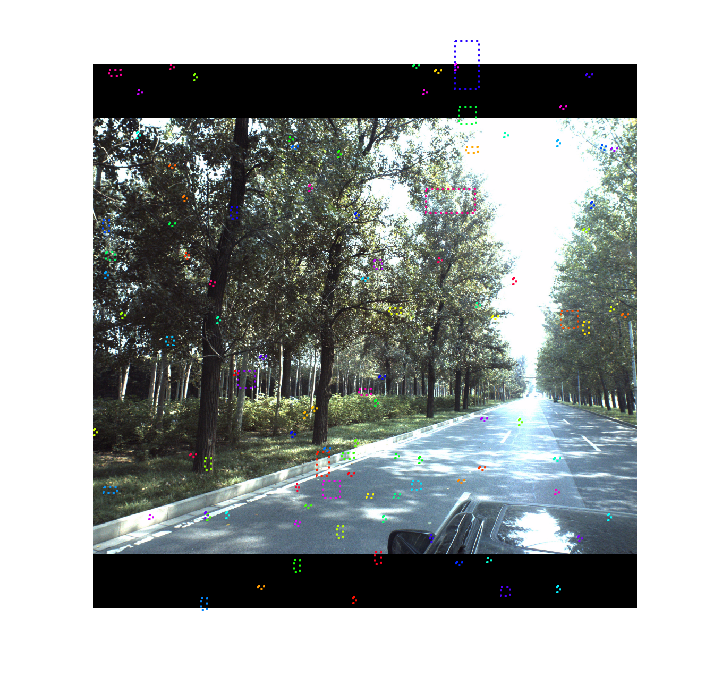

In [20]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

# ROIs

Positive ROIs:  29
Negative ROIs:  571
Positive Ratio: 0.05
Unique ROIs: 599 out of 600


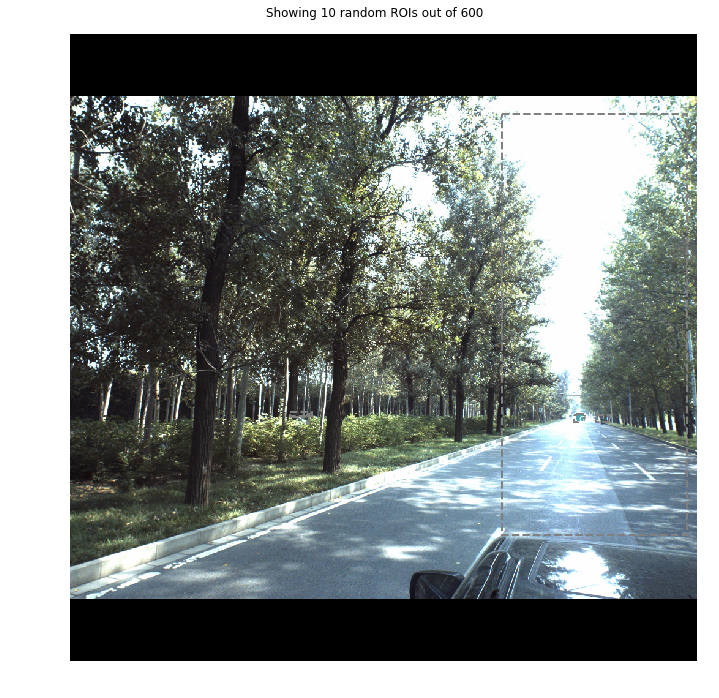

In [24]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

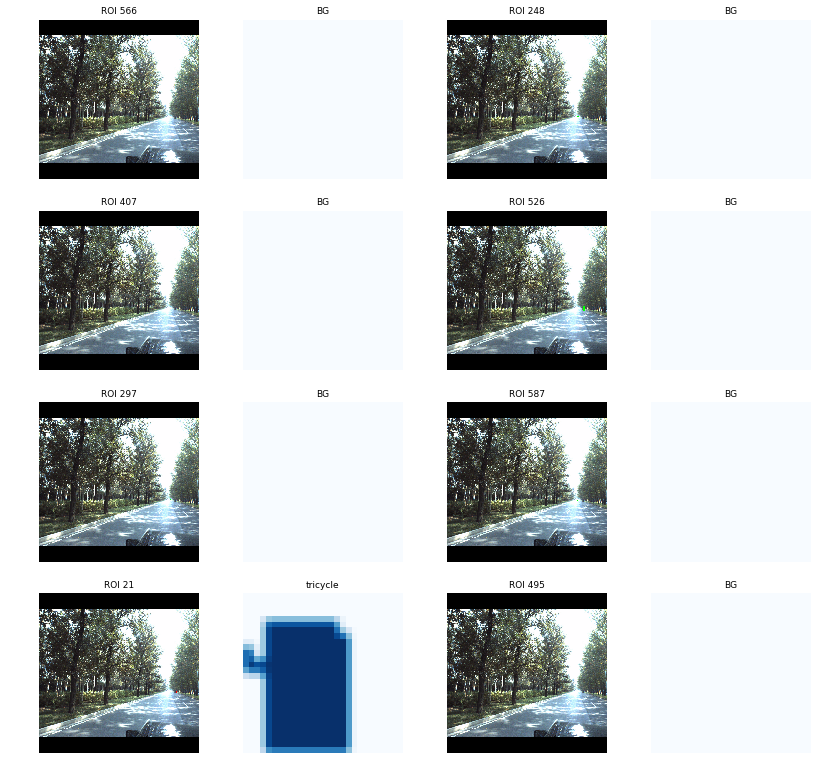

In [25]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [26]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

  133  0.22
  180  0.30
  109  0.18
  198  0.33
  101  0.17
  185  0.31
  198  0.33
  196  0.33
  182  0.30
  198  0.33
Average percent: 0.28
